# Create configs:
## Create a list of config files 
1) Create a base config file:
    1) Define the covariates dict `COVARS`
    2) Define the covariate to generative parameters relationship `RULES_COV_TO_GEN`
3) Iteratively increase or decrease a COV_TO_GEN relation and create multiple variations of the base config file.
    1) Define the number of steps of iteration
    2) Define the increment size
3) Test that the config file meets the expectation using `ToyBrainsData(config=...).show_current_config()`
4) Generate the datasets
5) For all covariates, estimate the maximum predictable accuracy from the generative attributes
    1) using linear/logistic regression model with $R^2$/$D^2$ metric for goodness-of-fit respectively.
    2) using SHAP


In [29]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
# standard python packages
import os, sys
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import matplotlib.image as mpimg
from sklearn import datasets, linear_model
import random
import math
from copy import copy, deepcopy

from create_toybrains import ToyBrainsData
from utils.vizutils import *
from utils.configutils import *

In [31]:
#1) Create a base config file:
basefilename = 'lblmidr_covsite'
#   a) Define the covariates dict `COVARS`
COVARS = {
            'cov_site'   : dict(states=['siteA', 'siteB']),
            'lbl_lesion' : dict(states=[True, False]),
         }
#   b) Define the covariate to generative parameters relationship `RULES_COV_TO_GEN`
# Rules about which covariate-state influences which generative variables
RULES_COV_TO_GEN = {
    ## (1) c --> X: `siteA -> brain intensity is higher` 
    'cov_site':{
        'siteA':{ 
            'brain-int_fill'  :  dict(amt=(50,40,2,1,1)),
            ## (2) c --> y: `siteA -> more likely to be lesion group` 
            'lbl_lesion' : dict(idxs=(1),amt=(0))
        },
        'siteB':{
            'brain-int_fill'  : dict(amt=(1,1,2,40,50)),
            ## (2) c --> y: `siteB -> more likely to be control group` 
            'lbl_lesion' : dict(idxs=(0),amt=(0))
        },
    },
    
    ## (3) X --> y: `lbl_lesion is True -> Volume of mid-right lesion is higher`
    'lbl_lesion':{
        True:{ 
            'shape-midr_curv'    :dict(amt=(8,5,5,3,2,2,1,1,1)), 
            'shape-midr_vol-rad' :dict(amt=(1,2,4,6))},
        False:{ 
            'shape-midr_curv'    :dict(amt=(1,1,1,2,2,3,5,5,8)), 
            'shape-midr_vol-rad' :dict(amt=(6,4,2,1))},
    },
}

# 3) Iteratively increase or decrease a COV_TO_GEN relation and create multiple variations of the base config file.
#   a) Define the number of steps of iteration
#   b) Define the increment size
tweak_rules =[
    ['cov_site', 'siteA', 'lbl_lesion', 'amt', lambda x: int((x+1)**1.75), 20],
    ['cov_site', 'siteB', 'lbl_lesion', 'amt', lambda x: int((x+1)**1.75), 20]
]

In [32]:
N_SAMPLES  = 10000
config_dirname = f'configs/{basefilename}'

In [33]:
! rm -rf $config_dirname
! rm -rf dataset/toybrains_n*$basefilename*

In [34]:
import pprint

# first create the base config file
config_fname = f'{config_dirname}/{basefilename}_t0.py'

if not os.path.exists(config_dirname):
    os.makedirs(config_dirname)

# 3) Save the config file
rules = deepcopy(RULES_COV_TO_GEN)
bl_result = create_config_file(
                config_fname, COVARS, rules, 
                show_dag_probas=False,
                return_baseline_results = True,
                gen_images=N_SAMPLES)
bl_results = [bl_result]

# next, iteratively tweak the config file and save these tweaked files
new_config_generated = True
i = 1
while new_config_generated:
    config_fname = f'{config_dirname}/{basefilename}_t{i}.py'
    rules, new_config_generated = apply_tweak_rules(rules, tweak_rules)
    # 2) Save the config file
    if new_config_generated:
        bl_result = create_config_file(
                        config_fname, COVARS, rules, 
                        show_dag_probas=False,
                        return_baseline_results=True,
                        gen_images=N_SAMPLES)
        bl_results.append(bl_result)
        i += 1

Sampling image gen. attributes for n=10000 toybrain samples


100%|██████████| 10000/10000 [00:31<00:00, 315.57it/s]


Generating n=10000 toybrain images


100%|██████████| 10000/10000 [07:32<00:00, 22.08it/s]


running a total of 45 different settings of [input] x [output] x [CV] and saving result in dataset/toybrains_n10000_lblmidr_covsite_t0


100%|██████████| 45/45 [00:02<00:00, 19.84it/s]


TOTAL RUNTIME: 0:00:03
Sampling image gen. attributes for n=10000 toybrain samples


100%|██████████| 10000/10000 [00:30<00:00, 323.13it/s]


Generating n=10000 toybrain images


100%|██████████| 10000/10000 [03:51<00:00, 43.20it/s]


running a total of 45 different settings of [input] x [output] x [CV] and saving result in dataset/toybrains_n10000_lblmidr_covsite_t1


100%|██████████| 45/45 [00:02<00:00, 19.08it/s]


TOTAL RUNTIME: 0:00:03
Sampling image gen. attributes for n=10000 toybrain samples


100%|██████████| 10000/10000 [00:30<00:00, 323.29it/s]


Generating n=10000 toybrain images


100%|██████████| 10000/10000 [03:52<00:00, 43.09it/s]


running a total of 45 different settings of [input] x [output] x [CV] and saving result in dataset/toybrains_n10000_lblmidr_covsite_t2


100%|██████████| 45/45 [00:02<00:00, 19.27it/s]


TOTAL RUNTIME: 0:00:03
Sampling image gen. attributes for n=10000 toybrain samples


100%|██████████| 10000/10000 [00:30<00:00, 325.72it/s]


Generating n=10000 toybrain images


100%|██████████| 10000/10000 [03:51<00:00, 43.20it/s]


running a total of 45 different settings of [input] x [output] x [CV] and saving result in dataset/toybrains_n10000_lblmidr_covsite_t3


100%|██████████| 45/45 [00:02<00:00, 19.28it/s]


TOTAL RUNTIME: 0:00:03
Sampling image gen. attributes for n=10000 toybrain samples


100%|██████████| 10000/10000 [00:31<00:00, 317.01it/s]


Generating n=10000 toybrain images


100%|██████████| 10000/10000 [03:50<00:00, 43.36it/s]


running a total of 45 different settings of [input] x [output] x [CV] and saving result in dataset/toybrains_n10000_lblmidr_covsite_t4


100%|██████████| 45/45 [00:02<00:00, 19.18it/s]


TOTAL RUNTIME: 0:00:04


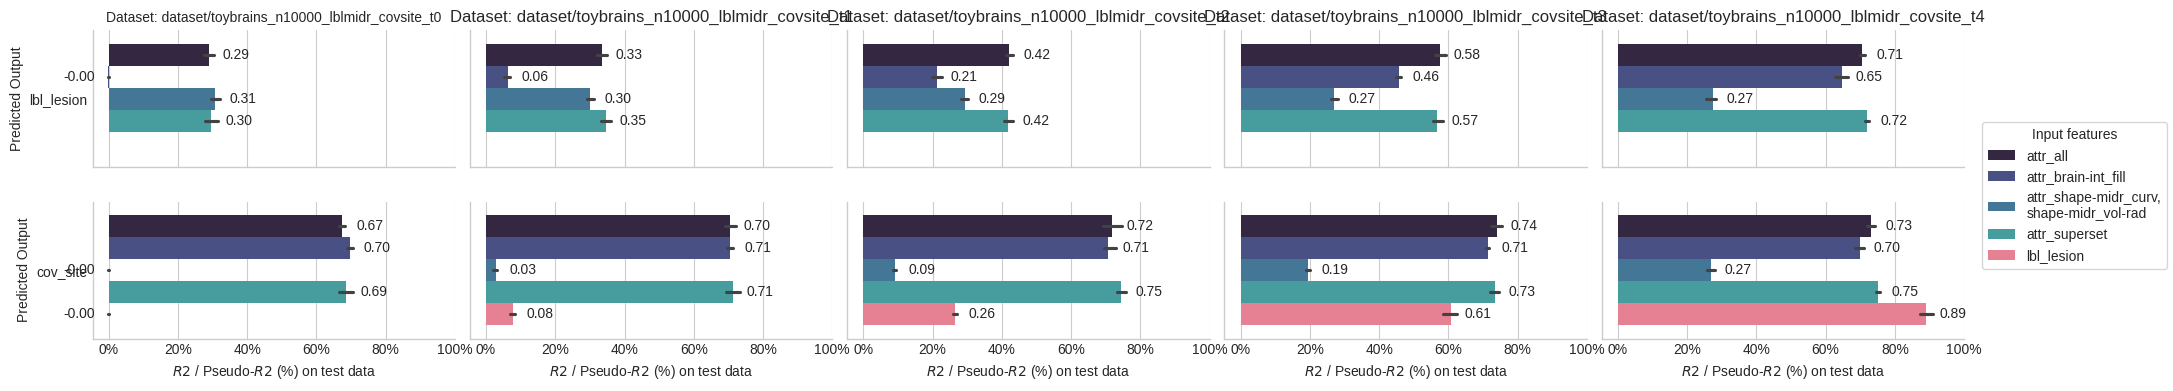

In [35]:
if len(bl_results) > 0:
    viz_baseline_results(bl_results)

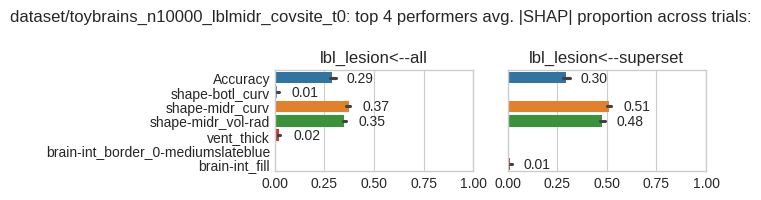

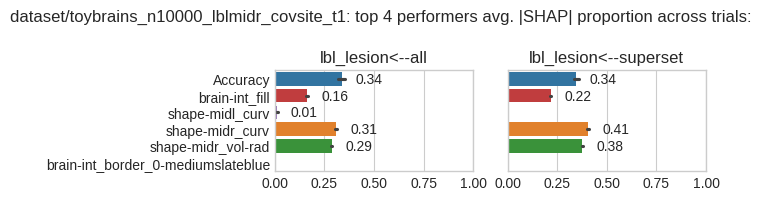

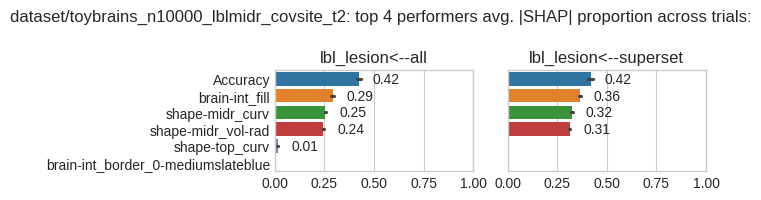

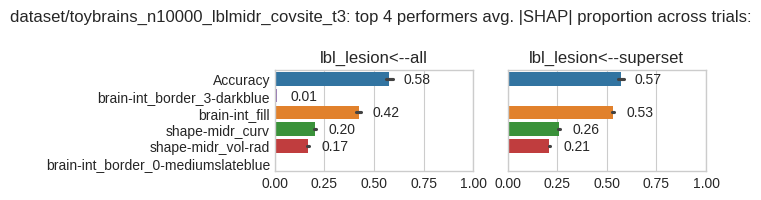

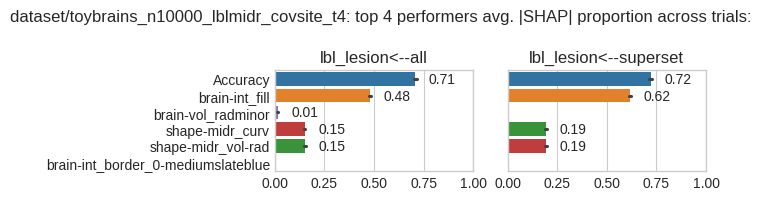

In [36]:
# test case for
for bl_result in bl_results:
    viz_baseline_results_shap(bl_result, labels=["lbl_lesion"], all_results=False)
    


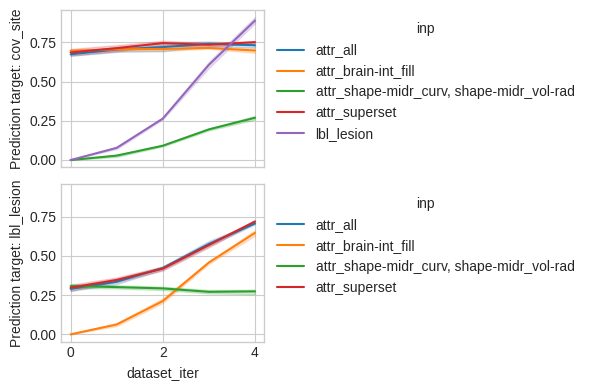

In [37]:
# plot the graph of how the accuracies change with the tweaks
if len(bl_results) > 0:
    viz_baseline_results_summary(bl_results)